In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
pd.set_option('precision', 0)

''' Construct the universal Results-Cyto- data file path in local drive named path
    Enter the row and a list of column indice you want to extract data 
    (e.g row E, column indice = [8, 9, 10])
    Construct a list of well IDs: B02-B10 named WELLS
    Construct a list of field IDs: fld1-fld9 named FIELD
'''
path_00hrs = './052018_plate1/Results-Cyto-'
path_48hrs = './052018_plate2/Results-Cyto-'

WELLS, rows, cols = [], ['B', 'C', 'D', 'E', 'F'], range(2, 11)

for r in rows:
    for k in cols:
        if k < 10:
            WELLS.append(r + '0{}'.format(k))
        else:
            WELLS.append(r + '10')
    
FIELD = ['fld{}'.format(k) for k in range(1, 10)]

files_00hrs = [path_00hrs + '{}{}.txt'.format(w, f) 
               for w in WELLS for f in FIELD]

files_48hrs = [path_48hrs + '{}{}.txt'.format(w, f) 
               for w in WELLS for f in FIELD]

''' Read all Cyto data files in the dataset into a list of dataframes
'''
df_00hrs = [pd.read_csv(file, sep='\t', 
                        engine='python', 
                        usecols=['Label']) for file in files_00hrs]

df_48hrs = [pd.read_csv(file, sep='\t', 
                        engine='python', 
                        usecols=['Label']) for file in files_48hrs]


''' Double check WELLS, FIELDs that have been processed
    Double check the number of files in 2 plates that have been read
'''
n1, n2 = len(df_00hrs), len(df_48hrs)
print(WELLS)
print(FIELD)
print('Number of files in plate 1 that have been read: ', n1)
print('Number of files in plate 2 that have been read: ', n2)

['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'E09', 'E10', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10']
['fld1', 'fld2', 'fld3', 'fld4', 'fld5', 'fld6', 'fld7', 'fld8', 'fld9']
Number of files in plate 1 that have been read:  405
Number of files in plate 2 that have been read:  405


In [2]:
def process(df_list, plate):
    well = r'[A-Z]+.*?(?=_)'
    field = r'(?<=d)[\d]{1,1}?(?=:)'
    cell_id = r'(\d+)-(\d+)'

    for k in range(len(df_list)):
        df_list[k]['Well'] = df_list[k]['Label'].\
                        apply(lambda x: re.search(well, x).group())
        
        df_list[k]['Field'] = df_list[k]['Label'].\
                        apply(lambda x: re.search(field, x).group())
        
        df_list[k]['Cell ID'] = df_list[k]['Label'].\
                        apply(lambda x: re.search(cell_id, x).group())
        
        df_list[k]['Plate'] = plate
        df_list[k] = df_list[k][['Cell ID', 'Well', 'Field', 'Plate']]
    
    return df_list

In [3]:
process(df_00hrs, 1)
process(df_48hrs, 2)
;

''

In [4]:
def extract(df_list):
    C = []
    for df in df_list:
        C.append([df.Well[0], 
                 int(df.Field[0]),
                 df.Plate[0],
                 int(df.shape[0] / df['Cell ID'].value_counts()[0])])

    df = pd.DataFrame(C, columns=['Well', 'Field', 'Plate', 'Total Cells'])
    df['Row'] = df['Well'].apply(lambda w: w[0])
    df['Col'] = df['Well'].apply(lambda w: 10 if w[-1] == '0' else int(w[-1]))
    df['Group'] = df['Col'].apply(lambda c: (c - 2)//3)
    df = df[['Well', 'Row', 'Col', 'Field', 'Group', 'Plate','Total Cells']]
    
    return df;

In [5]:
df1 = extract(df_00hrs)
df2 = extract(df_48hrs)
df  = df1.append(df2, ignore_index=True)

In [6]:
df

,Well,Row,Col,Field,Group,Plate,Total Cells
0,B02,B,2,1,0,1,949
1,B02,B,2,2,0,1,351
2,B02,B,2,3,0,1,861
3,B02,B,2,4,0,1,768
4,B02,B,2,5,0,1,350
...,...,...,...,...,...,...,...
805,F10,F,10,5,2,2,460
806,F10,F,10,6,2,2,544
807,F10,F,10,7,2,2,555
808,F10,F,10,8,2,2,565


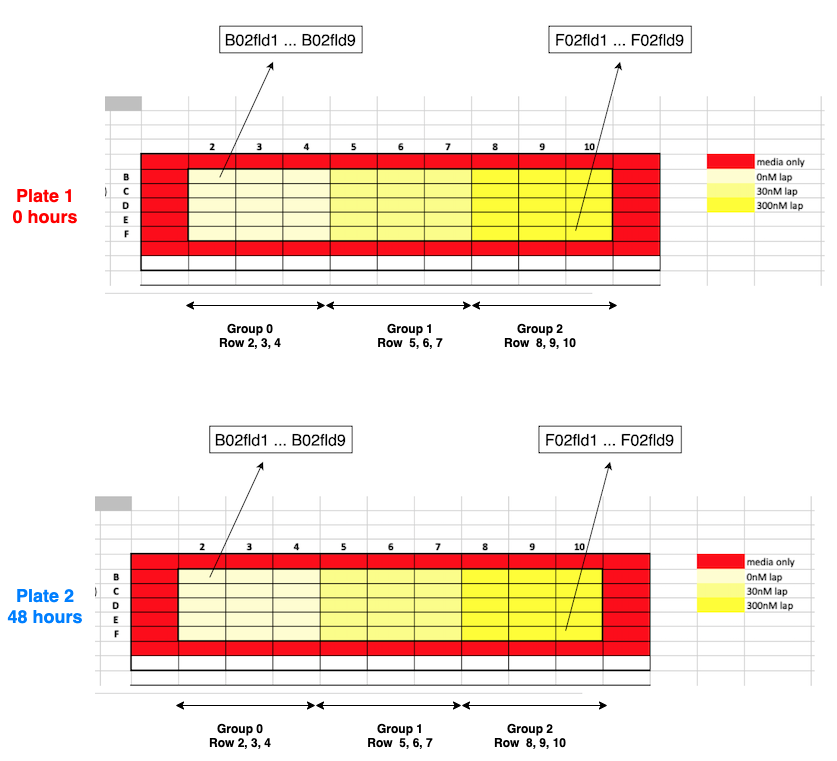

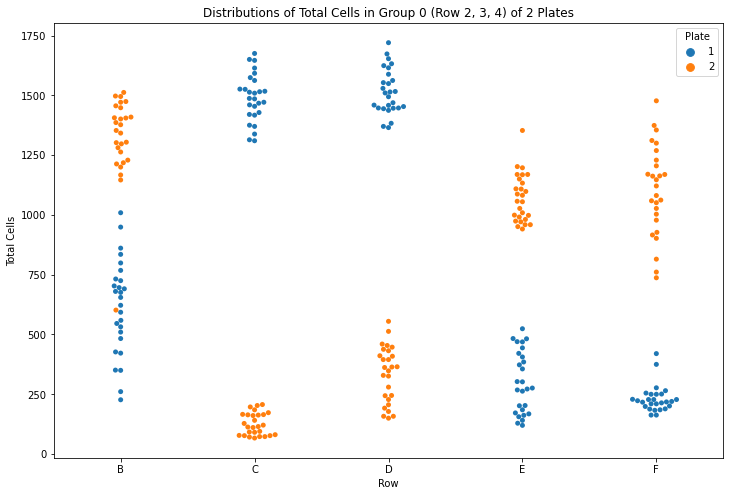

In [7]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
ax = sns.swarmplot(x='Row', y='Total Cells', hue='Plate', 
                   data=df[df.Group == 0])
ax.set_title('Distributions of Total Cells in Group 0 (Row 2, 3, 4) of 2 Plates')
plt.show()

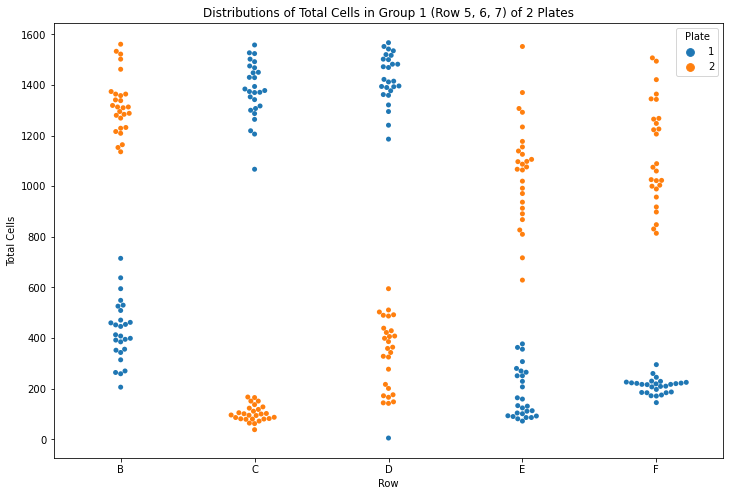

In [8]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
ax = sns.swarmplot(x='Row', y='Total Cells', hue='Plate', 
                   data=df[df.Group == 1])
ax.set_title('Distributions of Total Cells in Group 1 (Row 5, 6, 7) of 2 Plates')
plt.show()

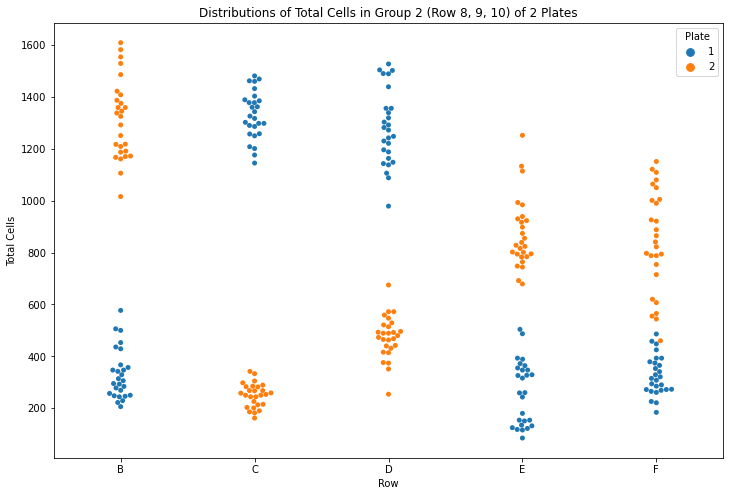

In [9]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
ax = sns.swarmplot(x='Row', y='Total Cells', hue='Plate', 
                   data=df[df.Group == 2])
ax.set_title('Distributions of Total Cells in Group 2 (Row 8, 9, 10) of 2 Plates')
plt.show()

In [10]:
agg = df['Total Cells'].groupby(by=[df['Row'], 
                                    df['Group'], 
                                    df['Plate']]).\
                        agg(['min', 'mean', 'max', 'std', 'sum'])

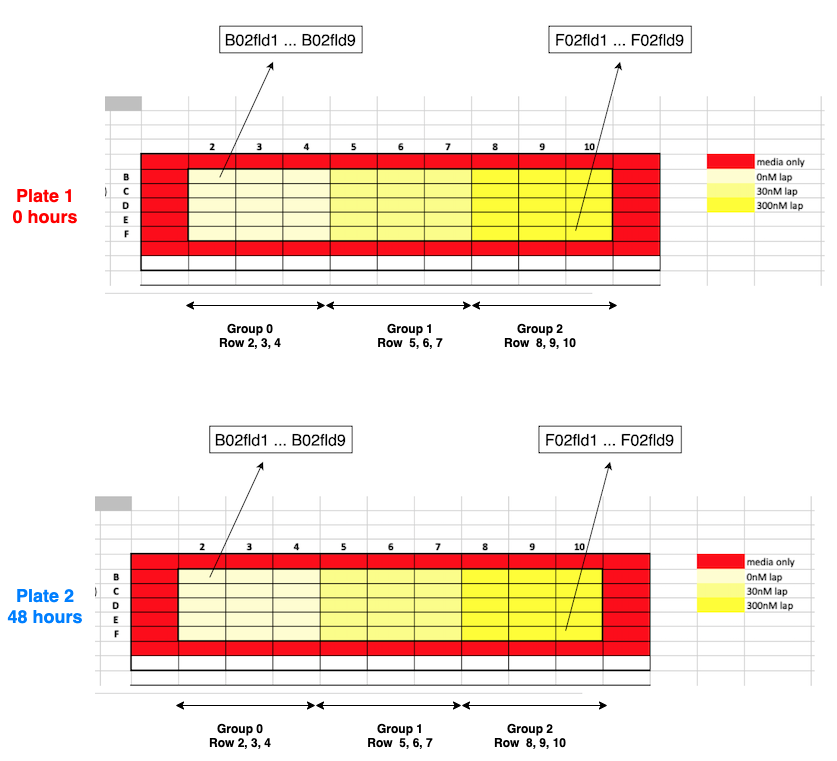

In [11]:
agg

min  mean   max  std    sum
Row Group Plate                              
B   0     1       227   617  1009  198  16662
          2       602  1321  1512  180  35654
    1     1       206   428   715  119  11563
          2      1136  1323  1561  114  35729
    2     1       206   331   577   96   8931
          2      1016  1312  1609  153  35435
C   0     1      1310  1489  1675  100  40214
          2        67   125   207   46   3388
    1     1      1067  1379  1558  112  37236
          2        38   102   167   32   2755
    2     1      1145  1330  1481   92  35914
          2       162   250   342   46   6756
D   0     1      1365  1515  1720   94  40910
          2       150   335   555  117   9042
    1     1         5  1374  1567  290  37108
          2       142   346   595  134   9329
    2     1       979  1280  1527  144  34560
          2       254   474   675   82  12795
E   0     1       120   301   524  129   8135
          2       941  1070  1353  100  28897
    1     1        72   181   377   98   4896
          2       629  1056  1552  202  28522
    2     1        85   263   504  123   7090
          2       679   871  1252  135  23505
F   0     1       163   231   420   56   6239
          2       737  1103  1477  187  29771
    1     1       145   211   295   30   5691
          2       814  1128  1507  203  30464
    2     1       184   326   486   76   8800
          2       460   845  1151  198  22821

In [12]:
def plot_sum(dt, row):
    sns.set(rc={'figure.figsize':(6,6)})
    sns.barplot(x='Group', y='sum', hue='Plate', 
                data=dt[dt.Row == row])
    plt.title('Total Cells in Each Group of Row {}'.format(row))
    plt.show()

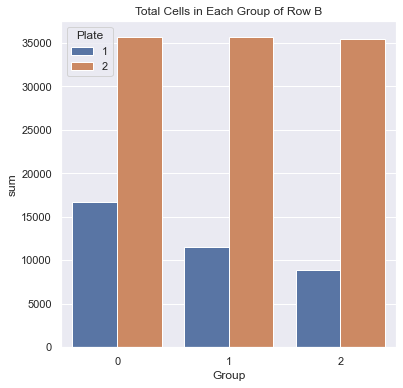

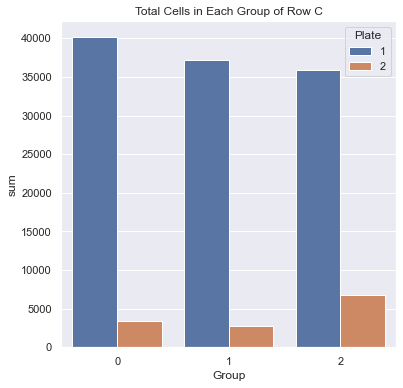

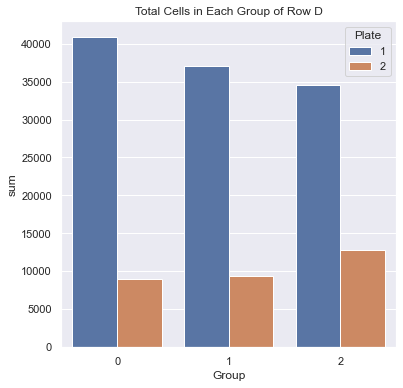

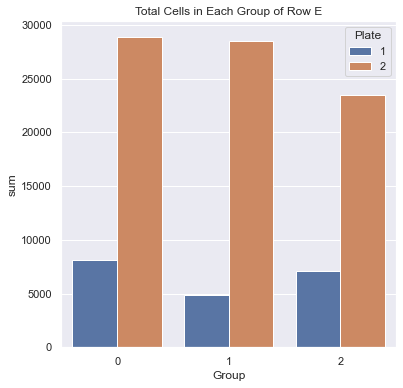

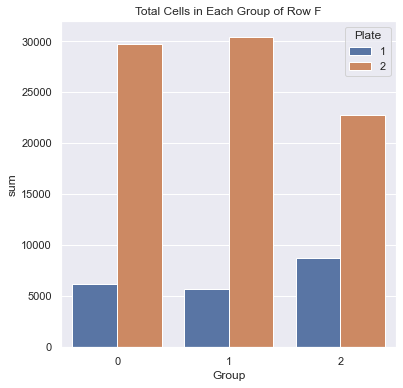

In [13]:
dt = agg.reset_index(level=['Plate', 'Group', 'Row'])
for row in rows:
    plot_sum(dt, row)